### Gaussian Process Regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("Packages loaded.")

Packages loaded.


### Define a kernel function

In [3]:
def k_se(x1,x2,gain=1.0,invlen=1.0):
    """
    Squared exponential kernel function
    """
    D_sq = distance.cdist(invlen*x1,invlen*x2,'sqeuclidean') 
    K = gain*np.exp(-D_sq)
    return K
print ("Done.")

Done.


### GP Prior

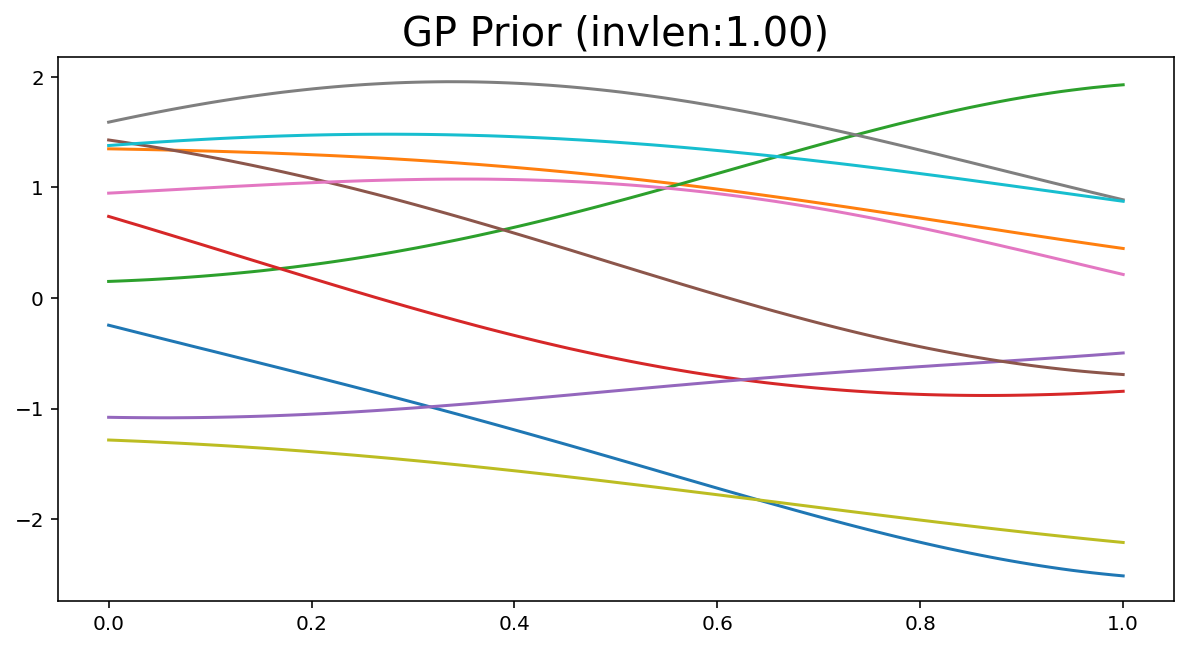

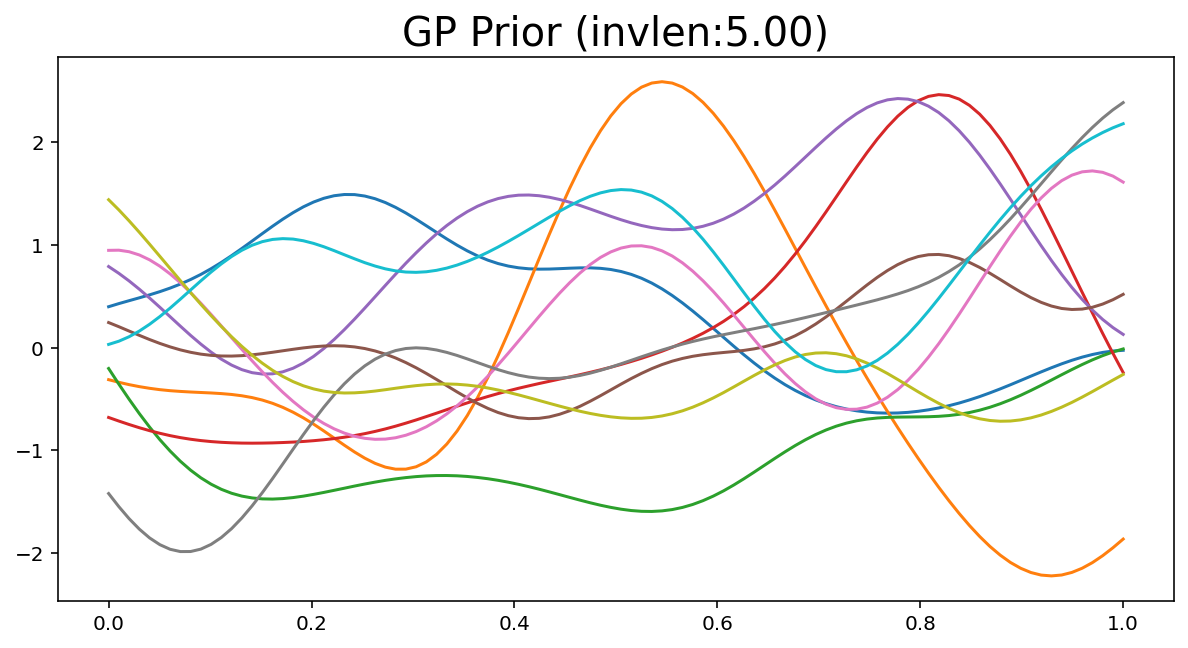

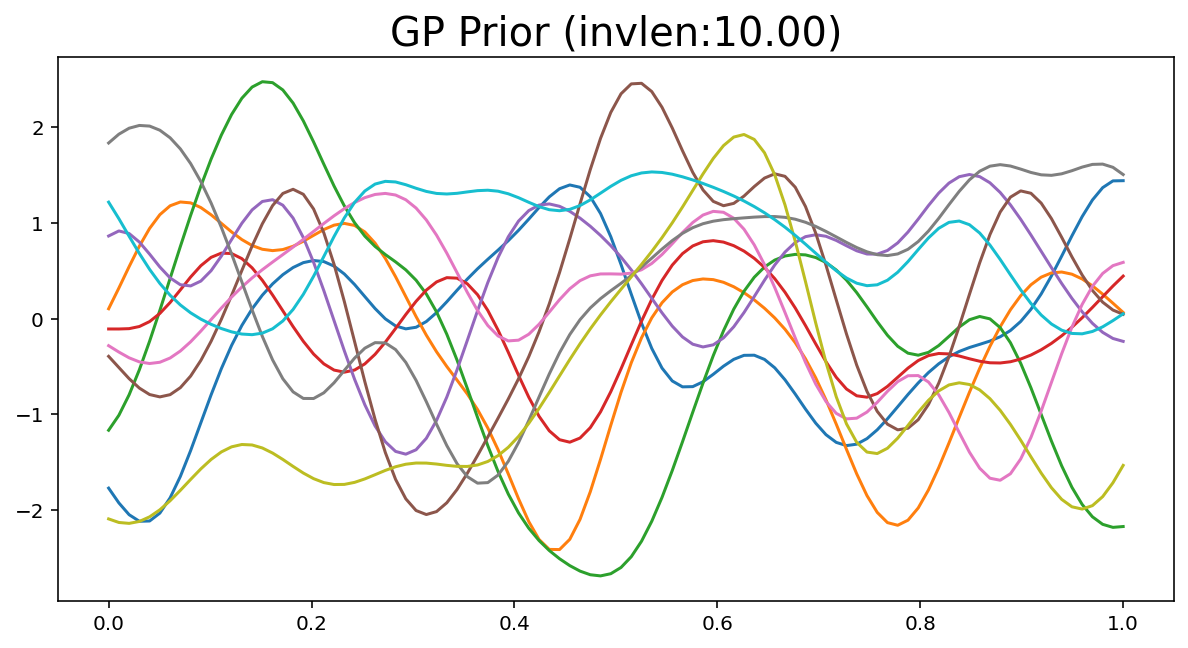

In [5]:
for invlen in [1,5,10]:
    n_data = 100
    t_data = np.linspace(start=0,stop=1.0,num=n_data).reshape((-1,1))
    K = k_se(x1=t_data,x2=t_data,gain=1.0,invlen=invlen)

    # Sample trajectories
    n_traj = 10
    K_chol = np.linalg.cholesky(K+1e-8*np.eye(n_data,n_data))
    sample_traj = np.matmul(K_chol,np.random.randn(n_data,n_traj))

    # Plot
    plt.figure(figsize=(10,5))
    for i_idx in range(n_traj):
        plt.plot(t_data,sample_traj[:,i_idx])
    plt.title('GP Prior (invlen:%.2f)'%(invlen),fontsize=20)
    plt.show()

### 1D Example

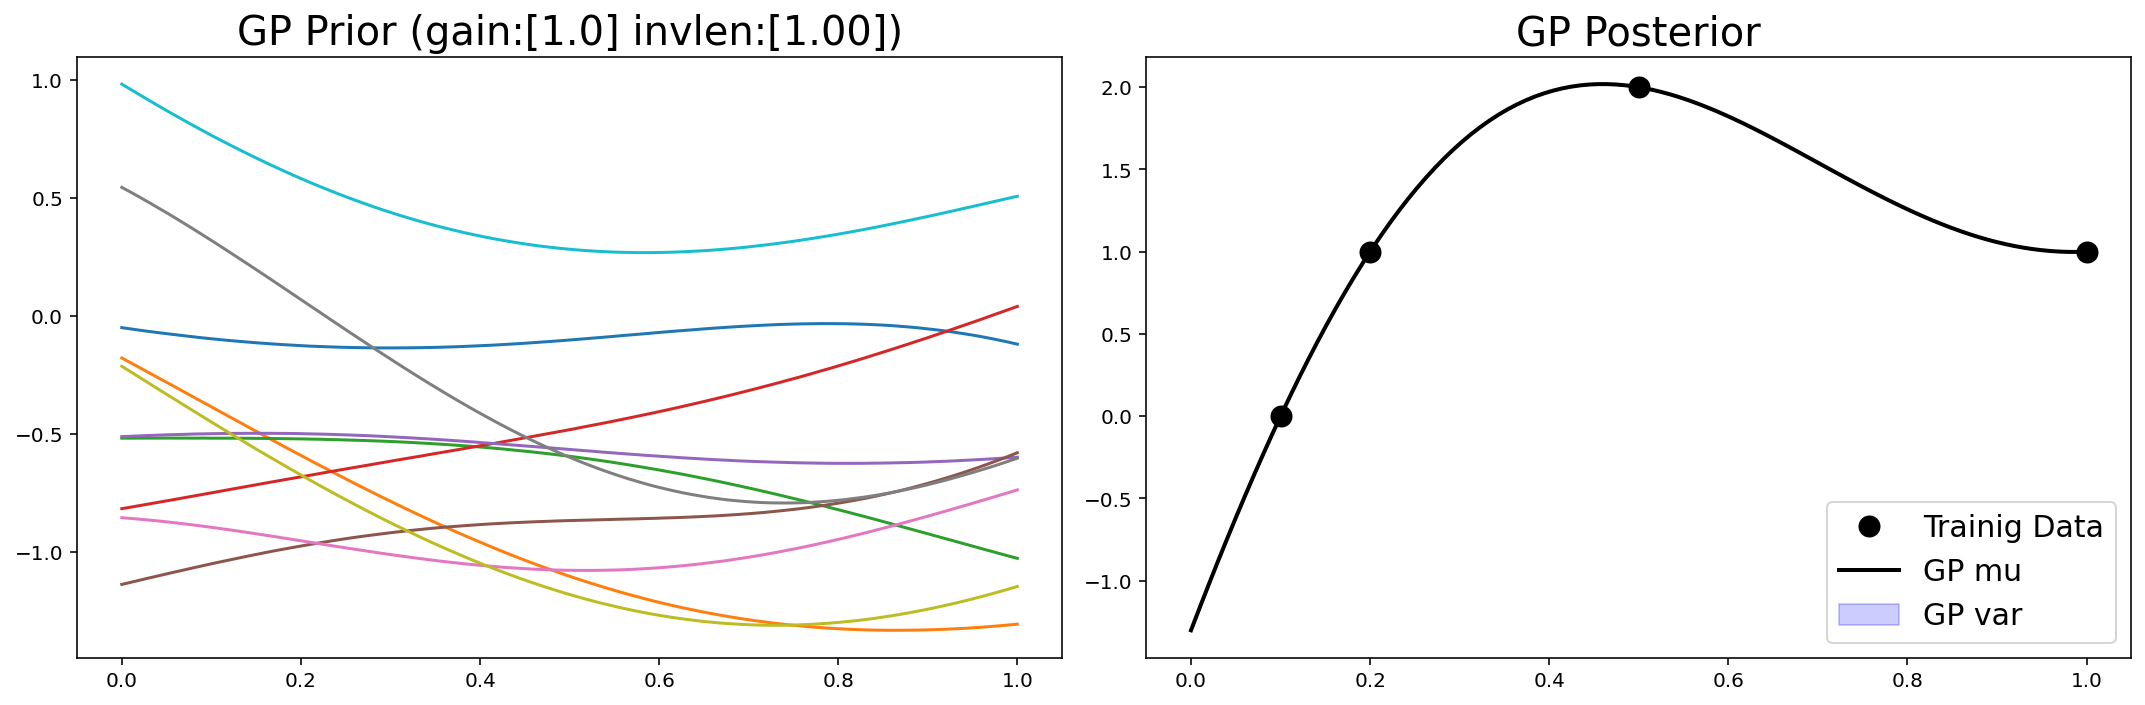

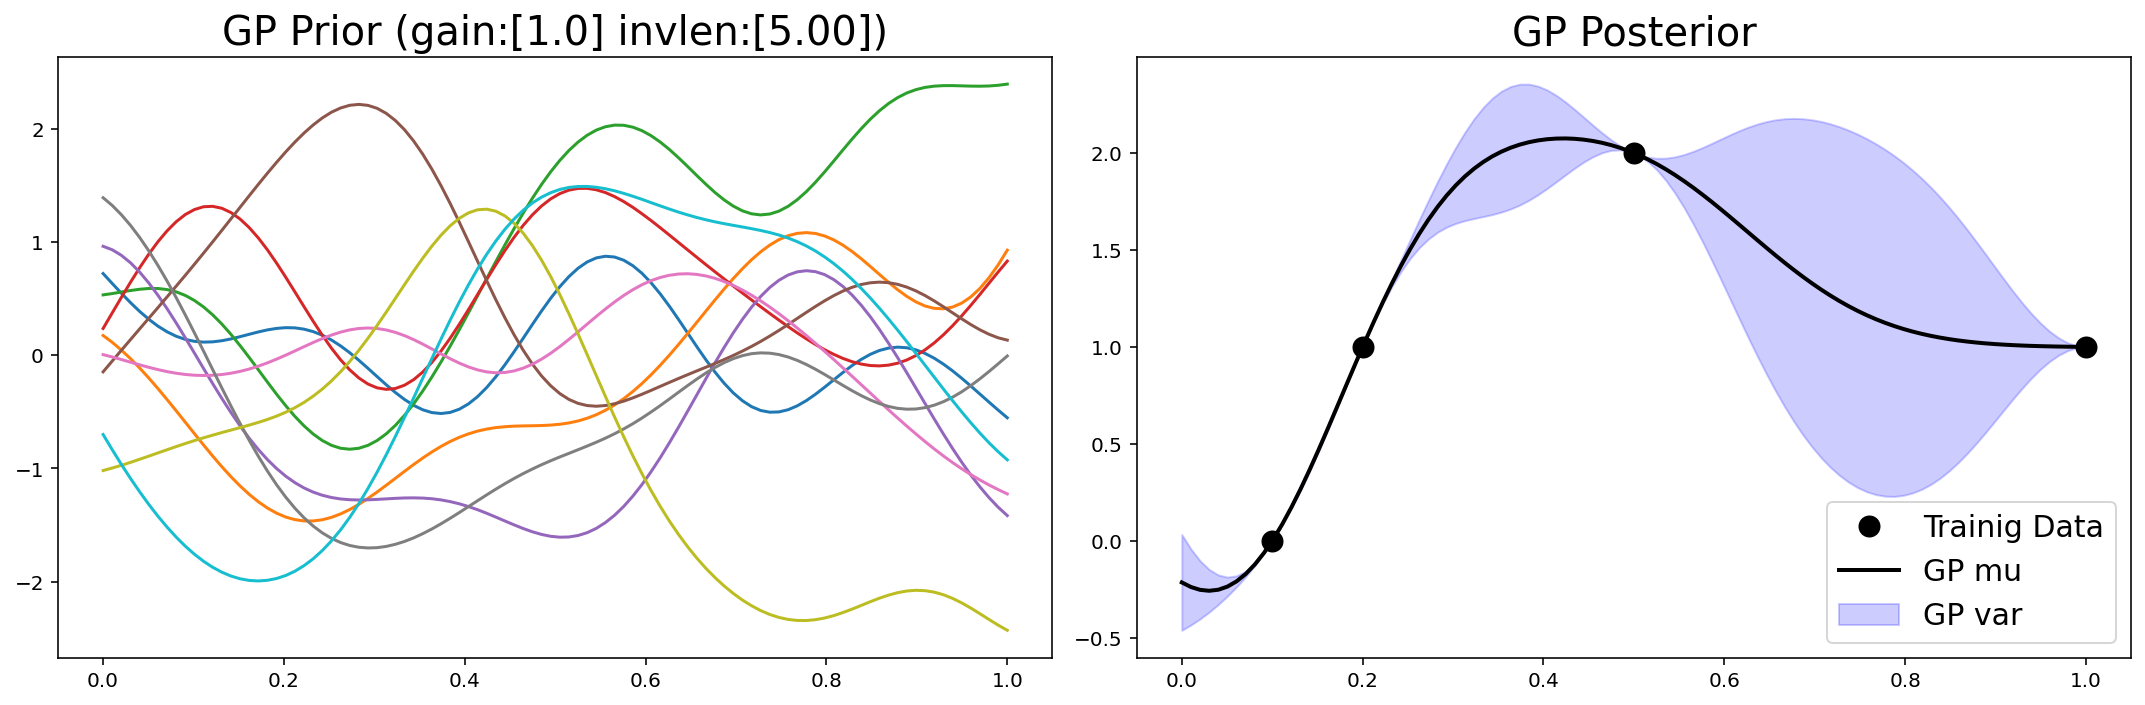

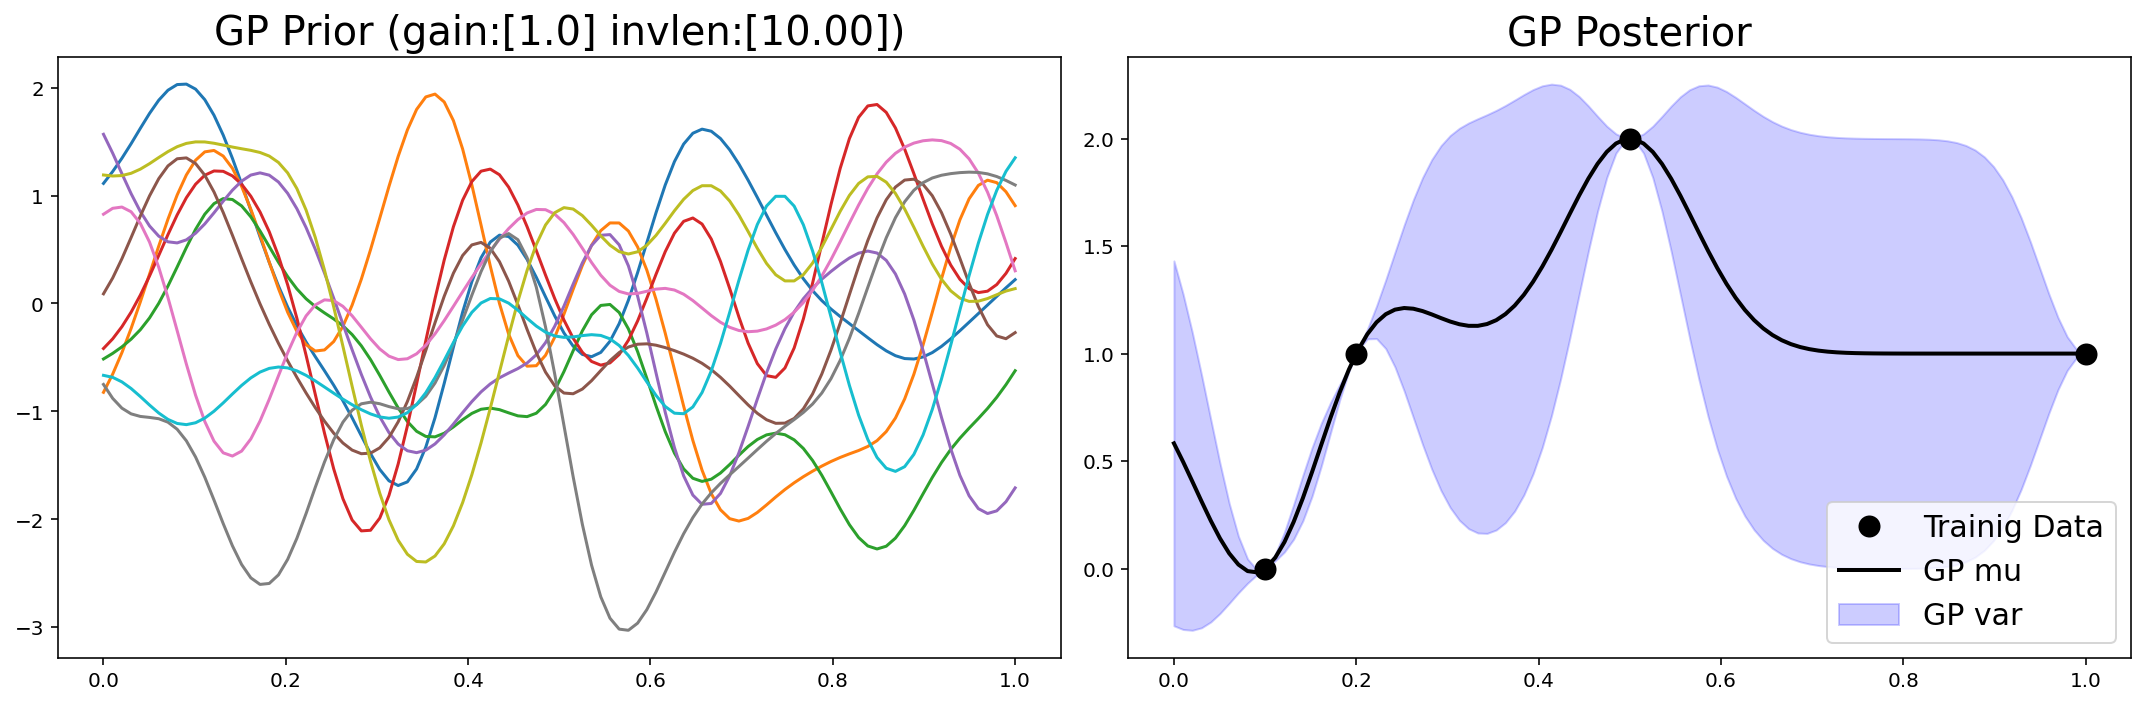

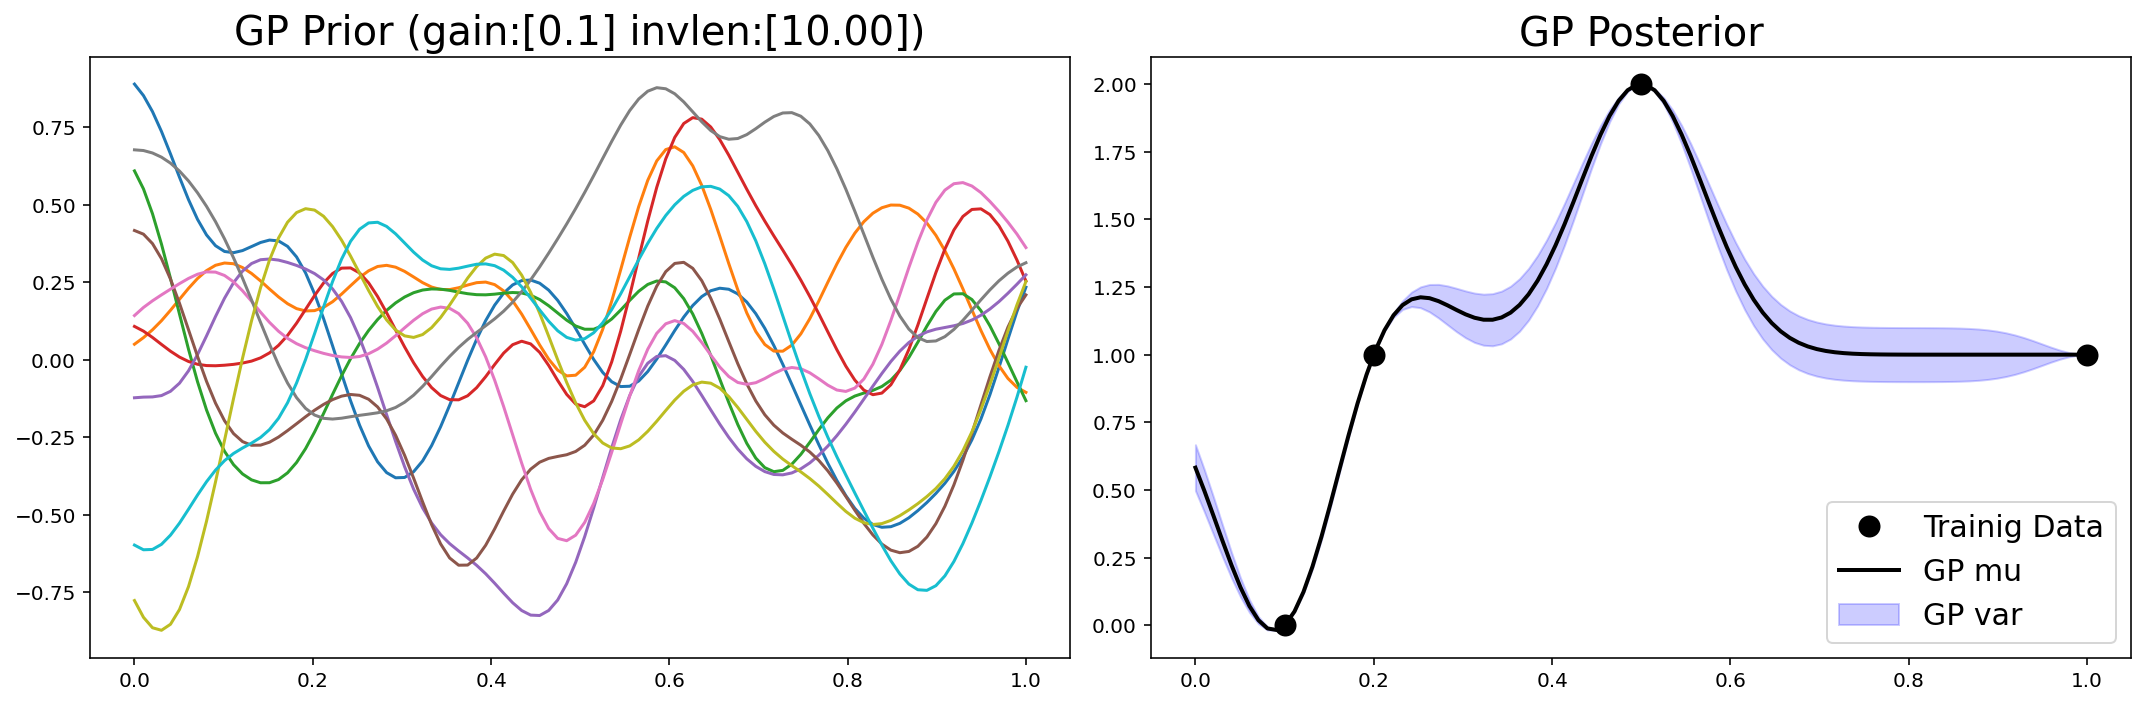

In [16]:
# Data
x_data = np.array([[0.1,0.2,0.5,1.0]]).T
y_data = np.array([[0.0,1.0,2.0,1.0]]).T
x_test = np.linspace(start=0,stop=1.0,num=100).reshape((-1,1))


for (gain,invlen) in [(1,1),(1,5),(1,10),(0.1,10)]:
    # Compute GP
    k_test = k_se(x_test,x_data,gain=gain,invlen=invlen)
    K = k_se(x_data,x_data,gain=gain,invlen=invlen)
    n = x_data.shape[0]
    eps = 1e-8
    inv_K = np.linalg.inv(K+eps*np.eye(n))
    mu_y = np.mean(y_data)
    mu_test = np.matmul(np.matmul(k_test,inv_K),y_data-mu_y)+mu_y
    var_test = (gain-np.diag(np.matmul(np.matmul(k_test,inv_K),k_test.T))).reshape((-1,1))


    t_data = np.linspace(start=0,stop=1.0,num=n_data).reshape((-1,1))
    K = k_se(x1=t_data,x2=t_data,gain=gain,invlen=invlen)
    n_traj = 10
    K_chol = np.linalg.cholesky(K+1e-8*np.eye(n_data,n_data))
    sample_traj = np.matmul(K_chol,np.random.randn(n_data,n_traj))

    # Plot GP prior
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    for i_idx in range(n_traj):
        plt.plot(t_data,sample_traj[:,i_idx])
    plt.title('GP Prior (gain:[%.1f] invlen:[%.2f])'%(gain,invlen),fontsize=20)

    # Plot GP posterior
    plt.subplot(1,2,2)
    plt.plot(x_data,y_data,'o',color='k',markersize=10,linewidth=3,label='Trainig Data')
    plt.plot(x_test,mu_test,'-',color='k',linewidth=2,label='GP mu')
    plt.fill_between(x_test.reshape(-1), 
                    (mu_test-var_test).reshape(-1),
                    (mu_test+var_test).reshape(-1),
                    alpha=0.2,color='b',label='GP var')
    plt.legend(fontsize=15,loc='lower right')
    plt.title('GP Posterior',fontsize=20)
    plt.tight_layout()
    plt.show()

### 2D Example

In [5]:
def x_grid(x0min,x0max,x0res,x1min,x1max,x1res):
    x0 = np.arange(x0min,x0max,x0res)
    x1 = np.arange(x1min,x1max,x1res)
    xx0,xx1 = np.meshgrid(x0,x1,sparse=False)
    return np.concatenate((xx0.reshape((-1,1)),xx1.reshape((-1,1))),axis=1),x0,x1

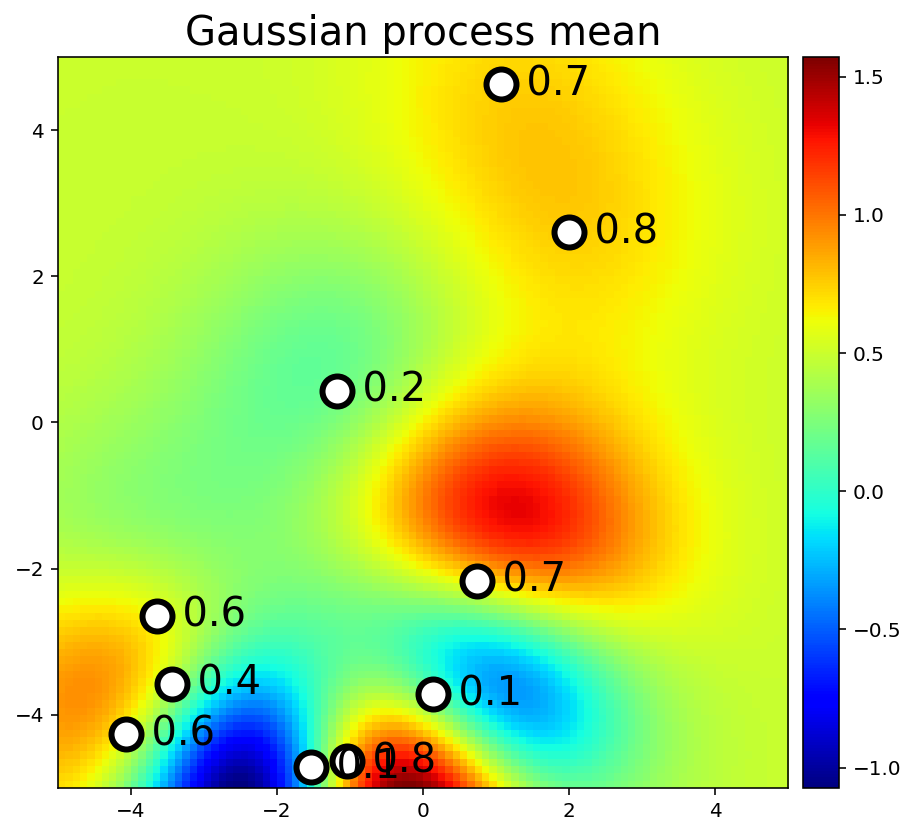

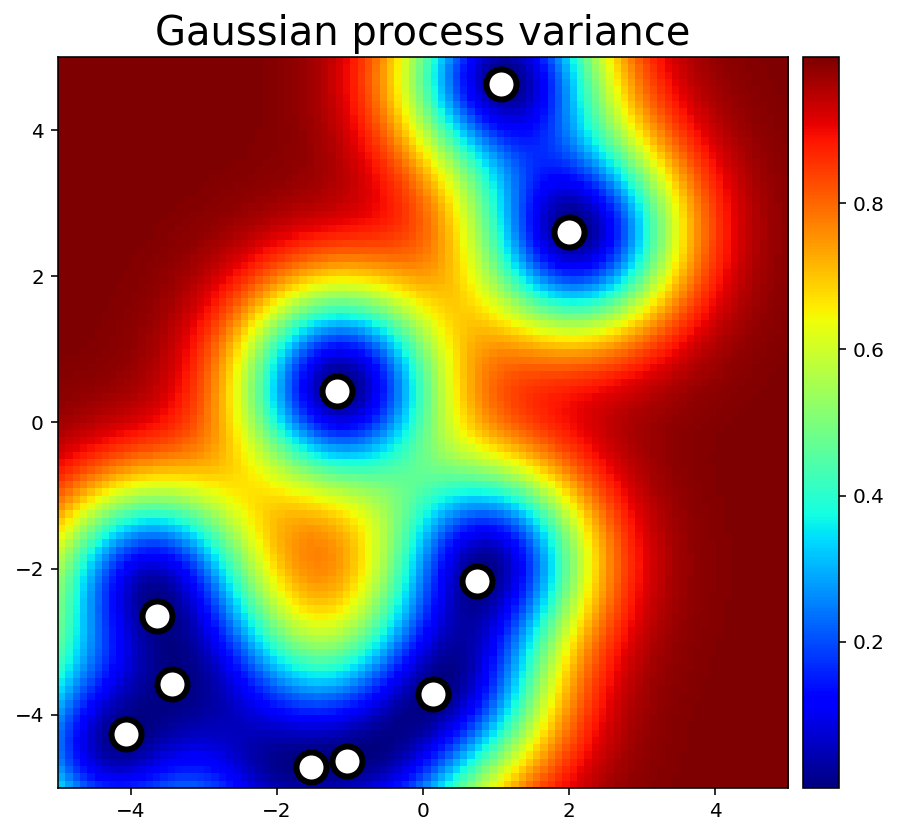

In [7]:
n_data = 10
x_data = 10*np.random.rand(n_data,2) - np.array([5,5])
y_data = 1*np.random.rand(n_data,1)
x_test,x0_test,x1_test = x_grid(-5,+5,0.1,-5,+5,0.1)

gain,invlen = 1.0,1/2
k_test = k_se(x_test,x_data,gain=gain,invlen=invlen)
K = k_se(x_data,x_data,gain=gain,invlen=invlen)
n = x_data.shape[0]
eps = 1e-8
inv_K = np.linalg.inv(K+eps*np.eye(n))
mu_y = np.mean(y_data)
mu_test = np.matmul(np.matmul(k_test,inv_K),y_data-mu_y)+mu_y
var_test = (gain-np.diag(np.matmul(np.matmul(k_test,inv_K),k_test.T))).reshape((-1,1))

# Reshape
mu_test_grid = mu_test.reshape((x1_test.shape[0],x0_test.shape[0]))
var_test_grid = var_test.reshape((x1_test.shape[0],x0_test.shape[0]))

# Plot
plt.figure(figsize=(7,7))
ax = plt.gca()
im = plt.imshow(mu_test_grid,extent=(-5,+5,-5,+5),origin='lower',cmap='jet')
plt.plot(x_data[:,0],x_data[:,1],'o',markersize=15,color='k',mew=3,mfc='w')
for i_idx in range(n_data):
    plt.text(x_data[i_idx,0],x_data[i_idx,1],'  %.1f'%(y_data[i_idx,0]),
             fontsize=20,verticalalignment='center',)
plt.title("Gaussian process mean",fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax) 
plt.show()

plt.figure(figsize=(7,7))
ax = plt.gca()
im = plt.imshow(var_test_grid,extent=(-5,+5,-5,+5),origin='lower',cmap='jet')
plt.plot(x_data[:,0],x_data[:,1],'o',markersize=15,color='k',mew=3,mfc='w')
plt.title("Gaussian process variance",fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax) 
plt.show()